In [2]:
import re 
import pandas as pd
import pywhatkit
import seaborn as sns
from urlextract import URLExtract
from wordcloud import WordCloud
from collections import Counter
import emoji
import matplotlib.pyplot as plt
import string
import numpy as np
import warnings
# warnings.simplefilter(action='ignore',category='RuntimeWarning')
extract = URLExtract()

In [3]:
def emoji_analysis(selected_user,df):
    if selected_user != 'Whole Squad':
        df = df[df['user'] == selected_user]

    emojis = []
    for message in df['message']:
        emojis.extend([c for c in message if c in emoji.UNICODE_EMOJI['en']])

    emoji_df = pd.DataFrame(Counter(emojis).most_common(len(Counter(emojis))),columns=['emoji','count'])

    return emoji_df

In [4]:
def most_common_words(selected_user,df):

    f = open('stop_hinglish.txt','r')
    stop_words = f.read()

    if selected_user != 'Whole Squad':
        df = df[df['user'] == selected_user]

    temp = df[df['user'] != 'group_notification']
    temp = temp[temp['message'] != '<Media omitted>\n']

    words = []

    for message in temp['message']:
        for word in message.lower().split():
            if word not in stop_words and string.punctuation:
                words.append(word)

    most_common_df = pd.DataFrame(Counter(words).most_common(20),columns=['msg','count'],index=None)
    return most_common_df


In [5]:
def get_wordcloud(selected_user,df):

    f = open('stop_hinglish.txt', 'r')
    stop_words = f.read()

    if selected_user != 'Whole Squad':
        df = df[df['user'] == selected_user]

    temp = df[df['user'] != 'group_notification']
    temp = temp[temp['message'] != '<Media omitted>\n']
    
    def removeStopWords(message):
        y = []
        for word in message.lower().split():
            if word not in stop_words:
                y.append(word)
        return " ".join(y)

    wc = WordCloud(width=500,height=500,min_font_size=10)
    temp['message'] = temp['message'].apply(removeStopWords)
    df_wc = wc.generate(temp['message'].str.cat(sep=" "))
    return df_wc

In [6]:
# This method will only work for whole sqad
def most_active_users(df):
    x = df['user'].value_counts().head()
    df = round((df['user'].value_counts() / df.shape[0]) * 100, 2).reset_index().rename(
        columns={'index': 'name', 'user': 'percent'})
    return x,df


In [7]:
def most_active_timePeriod(selected_user,df):

    if selected_user != 'Whole Squad':
        df = df[df['user'] == selected_user]

    user_heatmap = df.pivot_table(index='day_name', columns='period', values='message', aggfunc='count',fill_value=0)
    #Follows below method 
#     ind=np.where((df['period']=='10-11') & (df['day_name']=='Friday'))
#     df.loc[ind].shape[0]

    return user_heatmap

In [8]:
def daily_timeline(selected_user,df):

    if selected_user != 'Whole Squad':
        df = df[df['user'] == selected_user]

    daily_timeline = df.groupby('date_dt').count()['message'].reset_index()

    return daily_timeline

In [9]:
def monthly_timeline(selected_user,df):

    if selected_user != 'Whole Squad':
        df = df[df['user'] == selected_user]

    timeline = df.groupby(['year', 'month_num', 'month']).count()['message'].reset_index()

    timeline['time']=timeline['year'].apply(lambda x: str(x))+'-'+timeline['month']

    return timeline

In [10]:
def most_active_week(selected_user,df):

    if selected_user != 'Whole Squad':
        df = df[df['user'] == selected_user]

    return df['day_name'].value_counts()

In [11]:
def most_active_month(selected_user,df):

    if selected_user != 'Whole Squad':
        df = df[df['user'] == selected_user]

    return df['month'].value_counts()

In [12]:
def fetch_stats(selected_user,df):
    if selected_user != 'Whole Squad':
        df = df[df['user'] == selected_user]
        
    # fetch the number of messages
    num_messages = df.shape[0]

    # fetch the total number of words
    words = []
    for message in df['message']:
        words.extend(message.split())

    # fetch number of media messages
    num_media_messages = df[df['message'] == '<Media omitted>\n'].shape[0]

    # fetch number of links shared
    links = []
    for message in df['message']:
        links.extend(extract.find_urls(message))

    return selected_user,num_messages,len(words),num_media_messages,len(links)


In [13]:
def user_select(user_list):
    selected_user=input('Select For Which individual/squad u want to do analysis: ')
    return selected_user

In [14]:
def feature_extraction(data):
    data_new=re.sub('\s?(AM|PM)','',data)

    pattern='\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s'

    messages=re.split(pattern,data_new)[4:]
    dates=re.findall(pattern,data_new)[3:]

    dates_new = []
    for check in dates:
        check = re.sub('-', '', check)
        check = check.split()
        dates_new.append(''.join(check))

    df = pd.DataFrame({'user_message': messages, 'message_date': dates_new})
    # convert message_date type
    df['message_date'] = pd.to_datetime(df['message_date'],format='%m/%d/%y,%H:%M')

    df.rename(columns={'message_date': 'date'}, inplace=True)

    users = []
    messages = []
    for message in df['user_message']:
        entry = re.split('([\w\W]+?):\s', message)
        if entry[1:]:  # user name
            users.append(entry[1])
            messages.append(" ".join(entry[2:]))
        else:
            users.append('group_notification')
            messages.append(entry[0])

    df['user'] = users
    df['message'] = messages
    df.drop(columns=['user_message'], inplace=True)

    df['date_dt']=df['date'].dt.date
    df['year'] = df['date'].dt.year
    df['month_num'] = df['date'].dt.month
    df['month'] = df['date'].dt.month_name()
    df['day'] = df['date'].dt.day
    df['day_name'] = df['date'].dt.day_name()
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute

    period = []
    for hour in df[['day_name', 'hour']]['hour']:
        if hour == 12:
            period.append(str(hour) + "-" + str('01'))
        else:
            period.append(str(hour) + "-" + str(hour + 1))

    df['period'] = period
    df.to_csv('Converted_text.csv',index=False)

    return df

## From here the automation starts
Run below block only 1 time to extaract the meaningfull structed data from file we are loading

In [15]:
path='WhatsApp Chat with Purane Paapi😂.txt'# Replace this txt file with the file name for which u want to do analysis

file = open(path,encoding='utf-8')
if file is not None:
    data = file.read()
    df=feature_extraction(data)
    print('The file is loaded \n')
    display(df.head())

The file is loaded 



,date,user,message,date_dt,year,month_num,month,day,day_name,hour,minute,period
0,2015-09-07 08:29:00,ndevnani58,Shi londre\n,2015-09-07,2015,9,September,7,Monday,8,29,8-9
1,2015-09-07 08:32:00,Umesh,😂😂😂\n,2015-09-07,2015,9,September,7,Monday,8,32,8-9
2,2015-09-07 11:37:00,Umesh,<Media omitted>\n,2015-09-07,2015,9,September,7,Monday,11,37,11-12
3,2015-09-13 10:22:00,ndevnani58,Koi zindha h bhi iss grup me\n,2015-09-13,2015,9,September,13,Sunday,10,22,10-11
4,2015-09-13 10:22:00,ndevnani58,Umesh k alava\n,2015-09-13,2015,9,September,13,Sunday,10,22,10-11


## Run the below code multiple times as per the analyzing data of new user

All the participant with in this chat are: 
 ['Whole Squad', '+91 77425 09334', '+91 82900 26586', '+91 98283 42381', 'Ahmed', 'Ayush 2', 'Ayush Basandani', 'Mayank Ajmer', 'Mohit Ajmer', 'Nischay 2', 'Raghav', 'Sankalp Ajmer', 'Umesh', 'ndevnani58']

Select For Which individual/squad u want to do analysis: Mohit Ajmer

Below are the following observation for :  Mohit Ajmer
No of messages:  541 
No of words:  2468 
No of media:  55 
Links shared:  5

Devotion of time by user:  Mohit Ajmer


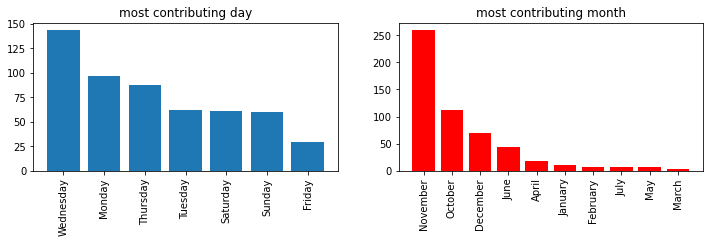

Time Line Analysis


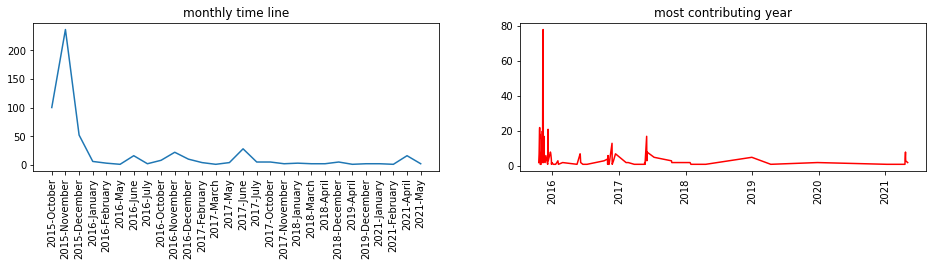


Time period on which user is most active



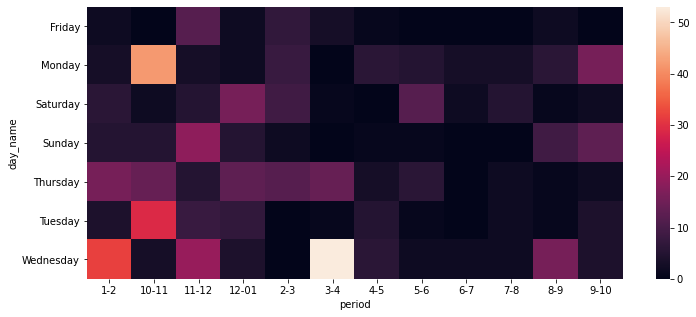

Word cloud for user:  Mohit Ajmer


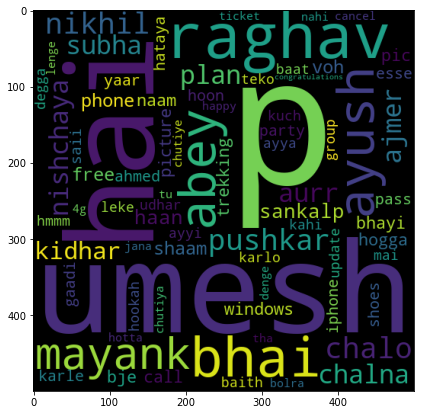

Most Frequent words by user:  Mohit Ajmer


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
msg,😂,😅,:p,umesh,hai?,raghav,😌,😂😂,😏,abey,chalo,ayush,pushkar,😛,subha,chalna,"bhai,",:),:'),aurr
count,83,61,25,21,21,15,13,12,11,11,10,10,9,9,8,8,8,8,8,7


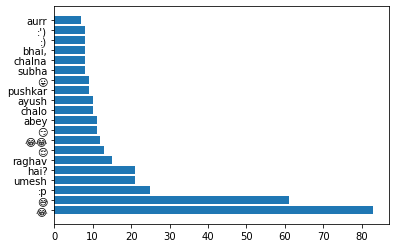

Emoji used by user:  Mohit Ajmer


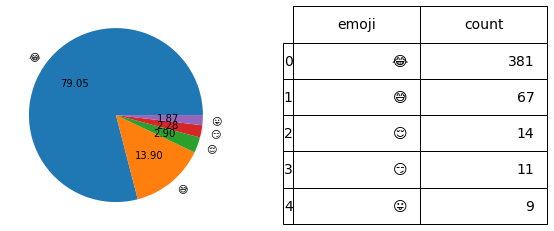

Do u want to send the message: no
Cool have a good day


In [16]:
user_list = df['user'].unique().tolist()
user_list.remove('group_notification')
user_list.sort()
user_list.insert(0,"Whole Squad")
    
print('All the participant with in this chat are: \n',user_list)
print()
selected_user = input('Select For Which individual/squad u want to do analysis: ')
    
selected_user,num_messages, words, num_media_messages, num_links = fetch_stats(selected_user,df)
    
result=fetch_stats(selected_user,df)
print('\nBelow are the following observation for : ',result[0])
print('No of messages: ',result[1],'\nNo of words: ', result[2],'\nNo of media: ',result[3],'\nLinks shared: ',result[4])
print('\nDevotion of time by user: ',selected_user)
    
plt.figure(figsize=(12,6))
ax1=plt.subplot(2,2,1)
plt.title('most contributing day')
week=most_active_week(selected_user,df)
ax1.bar(week.index,week.values)
plt.xticks(rotation='vertical')

ax2=plt.subplot(2,2,2)
plt.title('most contributing month')
mon=most_active_month(selected_user,df)
ax2.bar(mon.index,mon.values,color='r')
plt.xticks(rotation='vertical')
plt.show()

print('Time Line Analysis')

plt.figure(figsize=(16,6))
ax3=plt.subplot(2,2,3)
plt.title('monthly time line')
line=monthly_timeline(selected_user,df)
plt.plot(line['time'],line['message'])
plt.xticks(rotation='vertical')

ax4=plt.subplot(2,2,4)
plt.title('most contributing year')
daily_time=daily_timeline(selected_user,df)
plt.plot(daily_time['date_dt'],daily_time['message'],color='r')
plt.xticks(rotation='vertical')
plt.show()

print('\nTime period on which user is most active\n')
plt.figure(figsize=(12,5))
sns.heatmap(most_active_timePeriod(selected_user,df))
plt.yticks(rotation=360)
plt.show()

bbox=[0, 0, 1, 1]
font_size=14

if selected_user=='Whole Squad':
    print('Most active members of the group')
    user,data=most_active_users(df)
    fig=plt.figure(figsize=(10,4))
    
    ax5=fig.add_subplot(121)
    ax5.bar(user.index,user.values)
    plt.xticks(rotation='vertical')
    
    ax6 = fig.add_subplot(122)
    ax6.axis('off')
    mpl_table = ax6.table(cellText = data.values, rowLabels = data.index, bbox=bbox, colLabels=data.columns)
    mpl_table.set_fontsize(font_size)
    plt.show()
else:
    pass

print('Word cloud for user: ',selected_user)
word_cloud=get_wordcloud(selected_user,df)
fig,ax = plt.subplots(figsize=(15,7))
ax.imshow(word_cloud)
plt.show()

print('Most Frequent words by user: ',selected_user)
dataf=most_common_words(selected_user,df)
display(dataf.T)
plt.barh('msg','count',data=dataf)
plt.show()

print('Emoji used by user: ',selected_user)
bbox=[0, 0, 1, 1]
font_size=14

emo=emoji_analysis(selected_user,df).head()
fig=plt.figure(figsize=(10,4))

ax9=fig.add_subplot(121)
ax9.pie(x=emo['count'],labels=emo['emoji'],autopct='%0.2f')
    
ax10 = fig.add_subplot(122)
ax10.axis('off')
mpl_table = ax10.table(cellText = emo.values, rowLabels = emo.index, bbox=bbox, colLabels=emo.columns)
mpl_table.set_fontsize(font_size)
plt.show()

bol=input('Do u want to send the message: ')
if(bol=='True' or bol=='yes'):
    num,msg,hr,minu=input('Kindly share the contact no(prefix +91 no) ,msg , hour(24 hrs format) & minute to whom you want to share the msg: ').split(',')
    pywhatkit.sendwhatmsg(num,msg,int(hr),int(minu))
else:
    print('Cool have a good day')

In [ ]:
yes